This notebook reproduces the experimental results presented in our manuscript. Instructions for accessing the data are available in /data/README.md.

In [2]:
import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt

import scanpy as sc
import seaborn as sns

import sys 
sys.path.append("..") 
sys.path.append("../..") 

path="../../datasets/simulated_data/"
result_path=path.replace("datasets","results")

import scanpy as sc
adata=sc.read_h5ad(path+"adata_RNA.h5ad")
adata_adt=sc.read_h5ad(path+"adata_ADT.h5ad")
adata_atac=sc.read_h5ad(path+"adata_ATAC.h5ad")

adata.obs["anno"]=pd.read_table(path+"anno.txt",header=None).loc[adata.obs.index.astype("int")].values[:, 0].astype("str")

benchmarking=['MOFA+', 'MEFISTO', 'MultiVI', 'PRESENT', 'scMM', 'SpatialGlue', 'TotalVI','SpaMultiVAE','CellCharter','MISO','COSMOS','SMART']
paths=['adata_mofa.h5ad', 'adata_mefisto.h5ad', 'adata_MultiVI.h5ad', 'adata_present.h5ad', 'adata_scMM.h5ad', 'adata_SpatialGlue_1200.h5ad', 'adata_totalVI.h5ad', 
       'adataSpaMultiVAE.h5ad','adata_cellcharter.h5ad','adata_miso.h5ad','adata_COSMOS.h5ad','adata_SMART.h5ad']

cluster1,cluster2=5,6

In [43]:
from model.utils import pca
import muon.prot as pt
import muon.atac as ac
# RNA
sc.pp.filter_genes(adata, min_cells=10)

sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=3000)
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.scale(adata)

adata_omics1_high = adata[:, adata.var['highly_variable']]
adata.obsm['X_RNA'] = pca(adata_omics1_high, n_comps=30)

# Protein
adata_adt = adata_adt[adata.obs_names].copy() 
pt.pp.clr(adata_adt)
sc.pp.scale(adata_adt)
adata.obsm['X_ADT'] = pca(adata_adt, n_comps=30)

# ATAC
adata_atac = adata_atac[adata.obs_names].copy()  # .obsm['X_lsi'] represents the dimension reduced feature
ac.pp.tfidf(adata_atac, scale_factor=1e4)
sc.pp.normalize_per_cell(adata_atac, counts_per_cell_after=1e4)
sc.pp.log1p(adata_atac)
adata.obsm['X_ATAC'] = pca(adata_atac, n_comps=30)

In [44]:
import os
for i,j in zip(benchmarking,paths):
    if os.path.isfile(result_path+j):
        a=sc.read_h5ad(result_path+j)
        a.obs.index=[k.split('_')[0] for k in a.obs.index]
        print(a.obsm)
        a=a[adata.obs_names]
        adata.obsm[f"X_{i}"]=next(iter(a.obsm.values()))
        print(i,adata.obsm[f"X_{i}"].shape)

AxisArrays with keys: X_mofa, feat, nsfac, spatial, spfac
MOFA+ (1296, 50)
AxisArrays with keys: X_mefisto, feat, nsfac, spatial, spfac
MEFISTO (1296, 30)
AxisArrays with keys: embeddings, nsfac, spatial, spfac
PRESENT (1296, 64)
AxisArrays with keys: X_SpatialGlue, adj_feature, feat, nsfac, spatial, spfac
SpatialGlue (1296, 64)
AxisArrays with keys: X_cellcharter, X_scVI, spatial, spfac
CellCharter (1296, 150)
AxisArrays with keys: X_miso, nsfac, spatial, spfac
MISO (1296, 192)
AxisArrays with keys: SMART, feat, nsfac, spatial, spfac
SMART (1296, 64)


/home/ws6tg/anaconda3/envs/scvi/lib/python3.9/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


(AnnData object with n_obs × n_vars = 1296 × 0
     obs: 'atac_n_counts', 'rna_mod_weight', 'adt_mod_weight', 'atac_mod_weight', 'leiden'
     uns: 'leiden', 'leiden_colors', 'neighbors', 'umap'
     obsm: 'X_pca', 'X_umap', 'adt', 'atac', 'feat', 'nsfac', 'rna', 'spatial', 'spfac'
     obsp: 'connectivities', 'distances',
 AnnData object with n_obs × n_vars = 1296 × 0
     obs: 'atac_n_counts', 'leiden'
     uns: 'leiden', 'leiden_colors', 'neighbors', 'umap'
     obsm: 'X_pca', 'X_umap', 'adt', 'atac', 'feat', 'nsfac', 'rna', 'spatial', 'spfac'
     obsp: 'connectivities', 'distances')

In [3]:
adata_WNN=sc.read_h5ad(result_path+"adata_WNN.h5ad")
adata_SNF=sc.read_h5ad(result_path+"adata_SNF.h5ad")
adata_WNN,adata_SNF

(AnnData object with n_obs × n_vars = 1296 × 0
     obs: 'atac_n_counts', 'rna_mod_weight', 'adt_mod_weight', 'atac_mod_weight', 'leiden'
     uns: 'leiden', 'leiden_colors', 'neighbors', 'umap'
     obsm: 'X_pca', 'X_umap', 'adt', 'atac', 'feat', 'nsfac', 'rna', 'spatial', 'spfac'
     obsp: 'connectivities', 'distances',
 AnnData object with n_obs × n_vars = 1296 × 0
     obs: 'atac_n_counts', 'leiden'
     uns: 'leiden', 'leiden_colors', 'neighbors', 'umap'
     obsm: 'X_pca', 'X_umap', 'adt', 'atac', 'feat', 'nsfac', 'rna', 'spatial', 'spfac'
     obsp: 'connectivities', 'distances')

In [45]:
for i in adata.obsm:
    print(i,adata.obsm[i].shape)

nsfac (1296, 3)
spatial (1296, 2)
spfac (1296, 4)
X_RNA (1296, 30)
X_ADT (1296, 30)
X_ATAC (1296, 30)
X_MOFA+ (1296, 50)
X_MEFISTO (1296, 30)
X_PRESENT (1296, 64)
X_SpatialGlue (1296, 64)
X_CellCharter (1296, 150)
X_MISO (1296, 192)
X_SMART (1296, 64)


In [46]:
adata.obs[f"WNN_5"]=adata_WNN.obs["leiden"]

for r in np.arange(0.1,1.2,0.05):
    sc.tl.leiden(adata_SNF,resolution=r,key_added=f"SNF_{r}")
    ncluster=len(adata_SNF.obs[f"SNF_{r}"].unique())
    print(f"resolution={r},ncluster={ncluster}")
    if ncluster>=cluster2:
        break
        
for n in range(cluster1,cluster2):
    for i in adata_SNF.obs:
        if "SNF_" in i and len(adata_SNF.obs[i].unique())==n:
            adata.obs[f"SNF_{n}"]=adata_SNF.obs[i]
            break

resolution=0.1,ncluster=2
resolution=0.15000000000000002,ncluster=3
resolution=0.20000000000000004,ncluster=5
resolution=0.25000000000000006,ncluster=6


In [ ]:
import os

os.environ['R_HOME'] = '/public/home/cit_wlhuang/.conda/envs/smart/lib/R'

from model.utils import clustering
for i in ['MOFA+', 'MEFISTO']:
    print(i)
    for n in range(cluster1,cluster2):
        clustering(adata, key="X_"+i, add_key=f"{i}_{n}", n_clusters=n, method="gmm", use_pca=True)
        
for i in ['RNA', 'ADT','ATAC','PRESENT',  'SpatialGlue', 'SMART','CellCharter','MISO']:
    print(i)
    for n in range(cluster1,cluster2):
        clustering(adata, key="X_"+i, add_key=f"{i}_{n}", n_clusters=n, method="mclust", use_pca=True)


MOFA+
MEFISTO
RNA
fitting ...
  |======================================================================| 100%
ADT
fitting ...
  |======================================================================| 100%
ATAC
fitting ...
  |======================================================================| 100%
PRESENT
fitting ...
  |======================================================================| 100%
SpatialGlue
fitting ...
  |======================================================================| 100%
SMART
fitting ...
  |======================================================================| 100%
CellCharter
fitting ...
  |======================================================================| 100%
MISO
fitting ...
  |======================================================================| 100%


In [48]:
result_path=path.replace("datasets","results")
adata.write_h5ad(result_path+"adata_all.h5ad")

In [6]:
adata=sc.read_h5ad(result_path+"adata_all.h5ad")
adata

AnnData object with n_obs × n_vars = 1296 × 1000
    obs: 'anno', 'WNN_5', 'SNF_5', 'MOFA+_5', 'MEFISTO_5', 'mclust', 'RNA_5', 'ADT_5', 'ATAC_5', 'PRESENT_5', 'SpatialGlue_5', 'SMART_5', 'CellCharter_5', 'MISO_5'
    var: 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'hvg', 'log1p'
    obsm: 'X_ADT', 'X_ADT_pca', 'X_ATAC', 'X_ATAC_pca', 'X_CellCharter', 'X_CellCharter_pca', 'X_MEFISTO', 'X_MEFISTO_pca', 'X_MISO', 'X_MISO_pca', 'X_MOFA+', 'X_MOFA+_pca', 'X_PRESENT', 'X_PRESENT_pca', 'X_RNA', 'X_RNA_pca', 'X_SMART', 'X_SMART_pca', 'X_SpatialGlue', 'X_SpatialGlue_pca', 'nsfac', 'spatial', 'spfac'
    varm: 'nsload', 'spload'
    layers: 'counts'

In [13]:
for i,j in zip(benchmarking,paths):
    if i=="SMART":
        a=sc.read_h5ad(result_path+j)
        a.obs.index=[k.split('_')[0] for k in a.obs.index]
        a=a[adata.obs_names]
        print(a.obsm)
        adata.obsm[f"X_{i}"]=next(iter(a.obsm.values()))
        print(i,adata.obsm[f"X_{i}"].shape)
        
import os

os.environ['R_HOME'] = '/home/ws6tg/anaconda3/envs/EnvR43/lib/R/'       
from model.utils import clustering

# for i in ['MISO']:
#     print(i)
#     for n in range(cluster1,cluster2):
#         clustering(adata, key="X_"+i, add_key=f"{i}_{n}", n_clusters=n, method="gmm", use_pca=True)
for i in ['SMART']:
    print(i)
    for n in range(cluster1,cluster2):
        clustering(adata, key="X_"+i, add_key=f"{i}_{n}", n_clusters=n, method="mclust", use_pca=True)

AxisArraysView with keys: SMART, SMART_pca, feat, nsfac, spatial, spfac
SMART (1296, 64)
SMART
fitting ...
  |======================================================================| 100%


In [6]:
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.neighbors import kneighbors_graph
from scipy.stats import pearsonr

dis1=pairwise_distances(adata.obsm["X_ADT"])
dis2=pairwise_distances(adata.obsm["X_RNA"])
dis3=pairwise_distances(adata.obsm["X_ATAC"])
df=pd.DataFrame(columns=["methods","modality","pearsonr"])
for j in ['MOFA+', 'MEFISTO', 'PRESENT', 'SpatialGlue','SMART','CellCharter','MISO']:
    dis=pairwise_distances(adata.obsm[f"X_{j}"])
    for i in range(dis.shape[0]):
        corr, _ = pearsonr(dis[i], dis1[i])
        df.loc[len(df)]=[j,"ADT",corr]
        corr, _ = pearsonr(dis[i], dis2[i])
        df.loc[len(df)]=[j,"RNA",corr]
        corr, _ = pearsonr(dis[i], dis3[i])
        df.loc[len(df)]=[j,"ATAC",corr]

/tmp/ipykernel_1805713/3159735131.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(),rotation=45, ha='right')


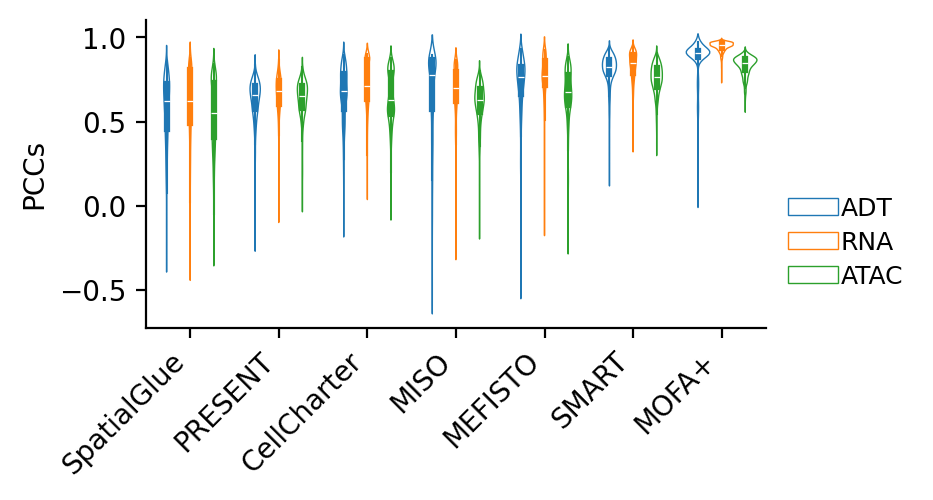

In [19]:
df_s=df[df["modality"]=="ADT"].groupby("methods")["pearsonr"].median()+df[df["modality"]=="RNA"].groupby("methods")["pearsonr"].median()+df[df["modality"]=="ATAC"].groupby("methods")["pearsonr"].median()


fig,ax = plt.subplots(figsize=(4,2),dpi=200)
sns.violinplot(df,x="methods",y="pearsonr",hue="modality", gap=.01,linewidth=0.5,width=0.8,fill=False,order=df_s.sort_values(ascending=True).index)
ax.set_ylabel("PCCs")
ax.set_xlabel("")
ax.set_xticklabels(ax.get_xticklabels(),rotation=45, ha='right')
ax.legend(bbox_to_anchor=(1,0.5),frameon=False,ncol=1,labelspacing=0.4,handletextpad=0.1,fontsize=9)
sns.despine()
fig.savefig("PCCs1.svg",format="svg",bbox_inches='tight',transparent=True)

In [9]:
df2=pd.DataFrame(columns=["cluster","modality","pearsonr"])
dis=pairwise_distances(adata.obsm[f"X_SMART"])
for i,j in enumerate(adata.obs["SMART_5"].values):
    corr, _ = pearsonr(dis[i], dis3[i])
    df2.loc[len(df2)]=[j,"ADT",corr]
    corr, _ = pearsonr(dis[i], dis2[i])
    df2.loc[len(df2)]=[j,"RNA",corr]
    corr, _ = pearsonr(dis[i], dis1[i])
    df2.loc[len(df2)]=[j,"ATAC",corr]

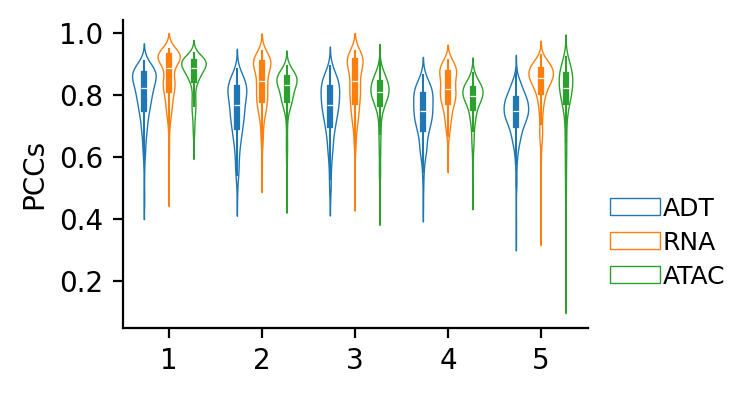

In [18]:
fig,ax = plt.subplots(figsize=(3,2),dpi=200)
sns.violinplot(df2,x="cluster",y="pearsonr",hue="modality", gap=.01,linewidth=0.5,width=0.8,fill=False)
ax.set_ylabel("PCCs")
ax.set_xlabel("")
ax.legend(bbox_to_anchor=(1,0.5),frameon=False,ncol=1,labelspacing=0.4,handletextpad=0.1,fontsize=9)
sns.despine()
fig.savefig("PCCs2.svg",format="svg",bbox_inches='tight',transparent=True)

In [7]:
color_dicts = {
    'MOFA+': '#1f77b4',     # blue
    'MEFISTO': '#ff7f0e',   # orange
    'MultiVI': '#2ca02c',   # green
    'PRESENT': '#d62728',   # red
    'scMM': '#9467bd',      # purple
    'SpatialGlue': '#8c564b',  # brown
    'TotalVI': '#e377c2',   # pink
    'SpaMultiVAE': '#7f7f7f',  # gray
    'CellCharter': '#bcbd22',  # yellow-green
    'MISO': '#17becf',      # cyan
    'COSMOS': '#FFC0CB',    # light pink
    'SMART': '#ff69b4',     # hot pink
    'SNF': '#ff6347',       # tomato red
    'WNN': '#4682b4',       # steel blue
}
}

/home/ws6tg/anaconda3/envs/scvi/lib/python3.9/site-packages/numba/core/decorators.py:246: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)
/tmp/ipykernel_1820832/840901371.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df1.loc[len(df1)]=[j,i,r["I"][0]]
/tmp/ipykernel_1820832/840901371.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df1.loc[len(df1)]=[j,i,r["I"][0]]
/tmp/ipykernel_1820832/840901371.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be t

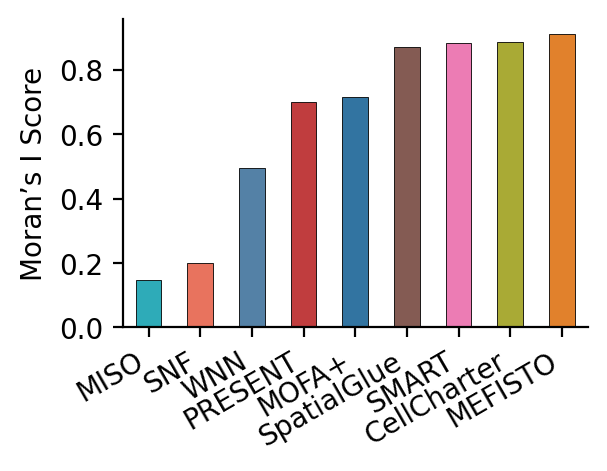

In [8]:
import squidpy as sq

df1=pd.DataFrame(columns=["method","cluster","morans_i"])
sc.pp.neighbors(adata, use_rep="spatial",n_neighbors=10)
for j in ['SNF','WNN','MOFA+', 'MEFISTO', 'PRESENT', 'SpatialGlue', 'SMART','CellCharter','MISO']:
    for i in range(5,6):
        r=sq.gr.spatial_autocorr(adata, connectivity_key='connectivities', genes=[f"{j}_{i}"], mode='moran',attr="obs",copy=True) 
        #alt = sc.metrics.morans_i(adata, obsm=f"X_{j}")
        df1.loc[len(df1)]=[j,i,r["I"][0]]
df1["method"]=df1["method"].map(lambda x:"SMART" if x=='SMART' else x)

fig,ax = plt.subplots(figsize=(3,2),dpi=200)
sns.barplot(df1,x="method",y="morans_i",linewidth=0.3,width=0.5,edgecolor="black",palette=color_dicts,order=df1.groupby("method")["morans_i"].median().sort_values(ascending=True).index)
ax.set_ylabel("Moran’s I Score")
ax.set_xlabel("")
ax.set_xticklabels(ax.get_xticklabels(),rotation=30, ha='right')
sns.despine()
fig.savefig("Moran.svg",format="svg",bbox_inches='tight',transparent=True)

In [15]:
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, adjusted_mutual_info_score, \
    homogeneity_score, mutual_info_score, v_measure_score,fowlkes_mallows_score,silhouette_score,\
    davies_bouldin_score,calinski_harabasz_score

result = pd.DataFrame(columns=["n_cluster","method","metries","score"])


for i in ['MOFA+', 'MEFISTO', 'WNN','SNF','PRESENT',  'SpatialGlue', 'SMART','CellCharter','MISO']:
    for j in range(cluster1,cluster2):
        try:
            n=f"{i}_{j}"
            ari = adjusted_rand_score(adata.obs['anno'], adata.obs[n])
            nmi = normalized_mutual_info_score(adata.obs['anno'], adata.obs[n])
            ami = adjusted_mutual_info_score(adata.obs['anno'], adata.obs[n])
            homogeneity = homogeneity_score(adata.obs['anno'], adata.obs[n])
            mutual_info = mutual_info_score(adata.obs['anno'], adata.obs[n])
            v_measure = v_measure_score(adata.obs['anno'], adata.obs[n])
            fmi=fowlkes_mallows_score(adata.obs['anno'], adata.obs[n])
        
            
        
            d={"ARI": ari,
                "NMI": nmi,
                "AMI": ami,
                "Homo": homogeneity,
                "MI": mutual_info,
                "V-Measure": v_measure,
                "FMI": fmi}
            
            for k,v in d.items():
                result.loc[len(result.index)]=[j,i,k,v]

            if f"X_{i}" in adata.obsm:
                d2={"SCI":silhouette_score(adata.obsm[f"X_{i}"],adata.obs[n]),
                    "DBI":davies_bouldin_score(adata.obsm[f"X_{i}"],adata.obs[n]),
                    "CH":calinski_harabasz_score(adata.obsm[f"X_{i}"],adata.obs[n])}
                for k,v in d2.items():
                    result.loc[len(result.index)]=[j,i,k,v]
           
            
        except:
            print(i)

result.to_csv(result_path+"result.csv")

In [4]:
result=pd.read_csv(result_path+"result.csv",index_col=0)

In [5]:
result=result[result["metries"].isin(["ARI","NMI","AMI","Homo","MI","V-Measure","FMI"])]
od=result.groupby("method")["score"].mean().sort_values(ascending=True).index
import seaborn as sns

/tmp/ipykernel_1820832/3003569075.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels())


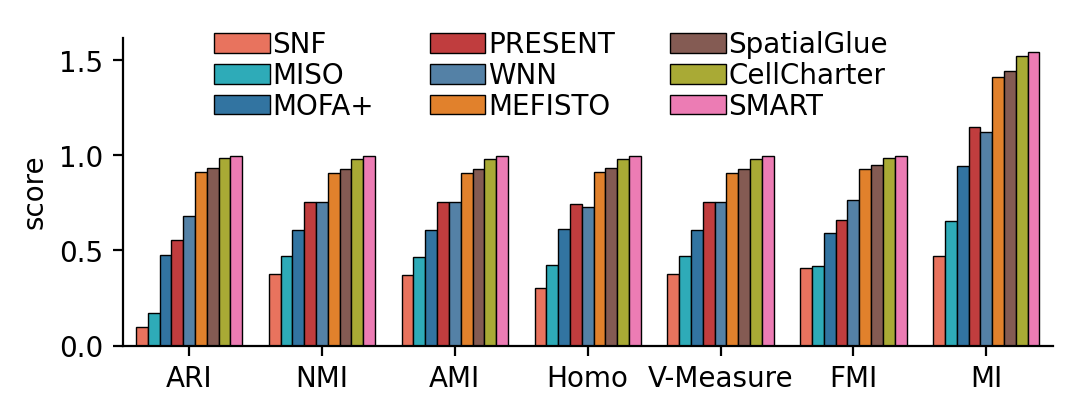

In [10]:
fig,ax = plt.subplots(figsize=(6,2),dpi=200)
result_6=result[result["n_cluster"]==5]
sns.barplot(x="metries",y="score",hue="method",data=result_6,ax=ax,width=0.8,palette=color_dicts,hue_order=od, edgecolor='black',linewidth=0.5,order=["ARI","NMI","AMI","Homo","V-Measure","FMI","MI"])
#ax.set_yticks([0,0.2,0.4,0.6,0.8])
ax.set_xlabel("")
ax.set_xticklabels(ax.get_xticklabels())
ax.legend(bbox_to_anchor=(0.85,0.65),frameon=False,ncol=3,labelspacing=0.1,handletextpad=0.1)
sns.despine()
fig.savefig("metries.svg",format="svg",bbox_inches='tight',transparent=True)

In [8]:
colors = [
    '#1f77b4',  # blue
    '#ff7f0e',  # orange
    '#2ca02c',  # green
    '#d62728',  # red
    '#9467bd',  # purple
    '#8c564b',  # brown
    '#e377c2',  # pink
    '#7f7f7f',  # gray
    '#bcbd22',  # yellow
    '#17becf',  # cyan
    '#4a90e2',  # dark blue
    '#f5a623',  # dark orange
    '#7ed321',  # dark green
    '#d0021b',  # dark red
    '#8b6bbf',  # dark purple
    '#a7a8aa',  # dark gray
]
colordict=dict(zip(adata.obs["anno"].unique(),colors))
colordict

{'1': '#1f77b4',
 '2': '#ff7f0e',
 '3': '#2ca02c',
 '4': '#d62728',
 '5': '#9467bd'}

In [ ]:
import matplotlib.pyplot as plt

plt.rcdefaults()
plt.rcParams["axes.titlesize"] = 11
plt.rcParams["legend.fontsize"] = 8               
plt.rcParams["legend.title_fontsize"] = 9 

1
4
5
5


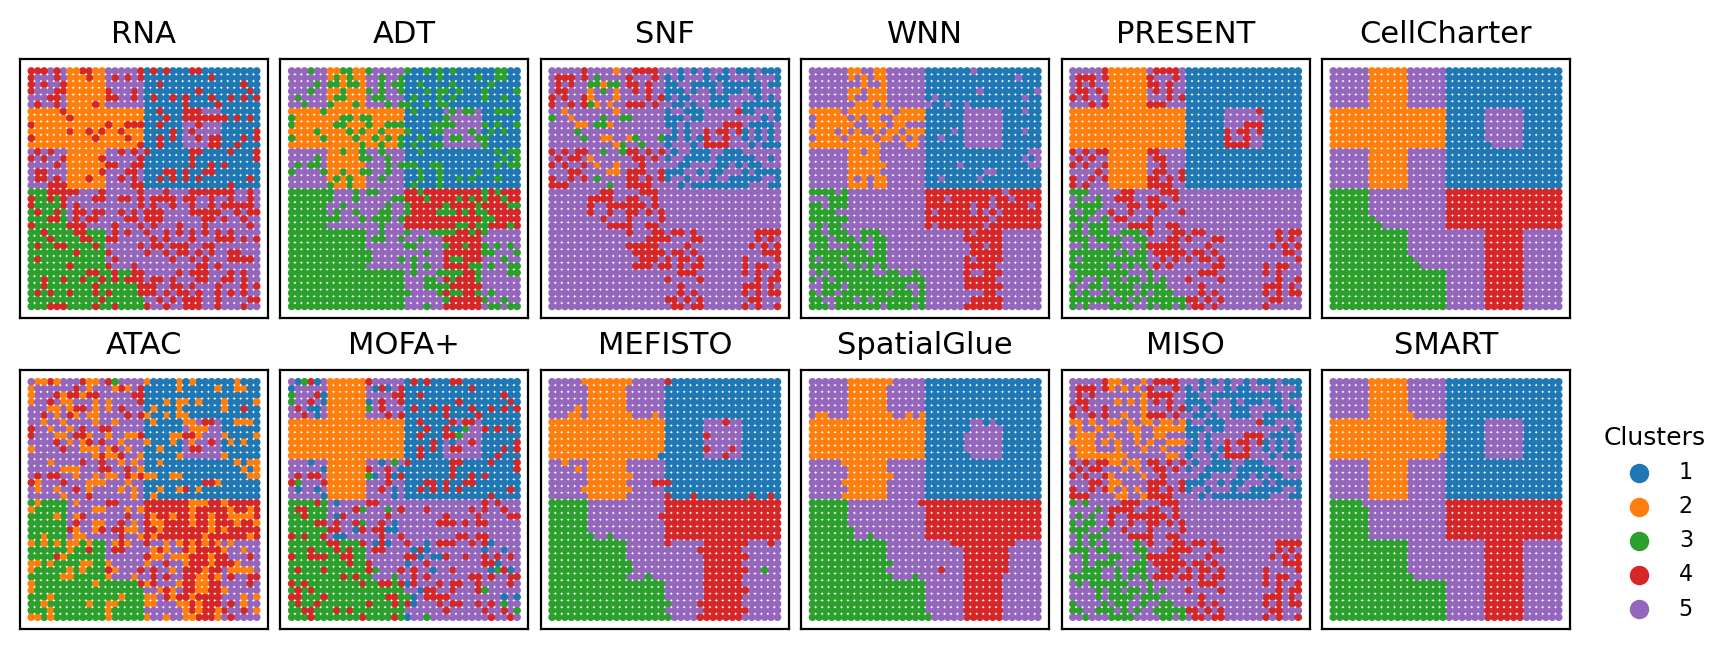

In [16]:
from model.utils import getcolordict
#gs = gridspec.GridSpec(2, 16)
fig, ax_list = plt.subplots(2, 6, figsize=(10, 3.7),dpi=200)
plt.subplots_adjust(hspace=0.2, wspace=0.05)
for i,j in enumerate(['RNA',  'ADT', 'SNF','WNN', 'PRESENT','CellCharter']+[  'ATAC','MOFA+', 'MEFISTO', 'SpatialGlue','MISO','SMART']):
    adata.obs[j+"_5"]=adata.obs[j+"_5"].astype("str")
    colordict1=getcolordict(adata,j+"_5",'anno',colordict)
    #ax=plt.subplot(gs[i//8, 2*(i%8):2*(i%8)+2])
    ax=ax_list[i//6,i%6]
    sc.pl.embedding(adata, basis='spatial', color=j+"_5", ax=ax, s=30,palette=colordict1, show=False)
    ax.set_title(j)
    ax.set_xlabel("")
    ax.set_ylabel("")
    #ax.axis("off")
    if i!=11:
        ax.get_legend().remove()
    else:
        ax.legend(loc=(1.1,0),frameon=False,title='Clusters')
fig.savefig("cluster1.svg",format="svg",bbox_inches='tight',transparent=True)

1
4
5
5


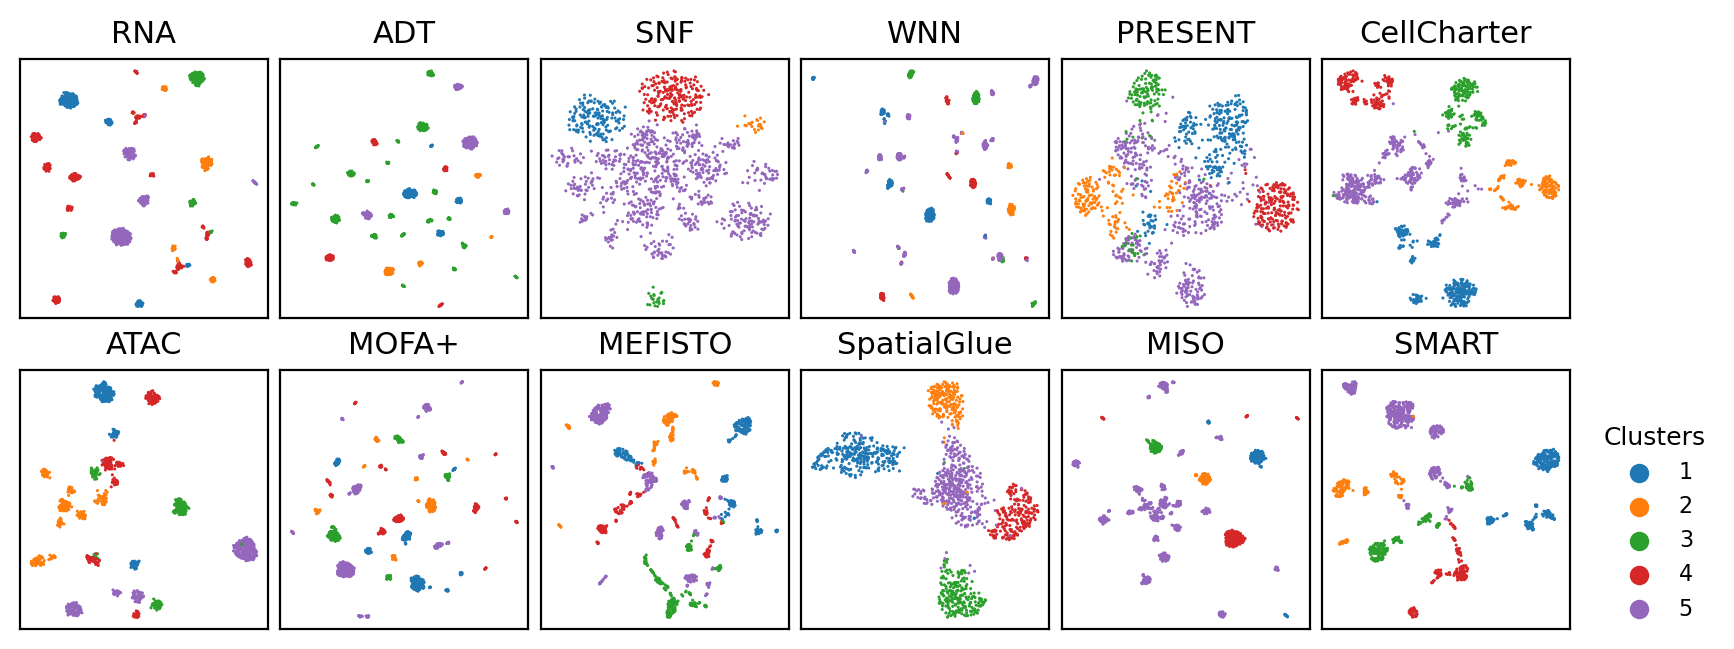

In [23]:
#gs = gridspec.GridSpec(2, 12)
fig, ax_list = plt.subplots(2, 6, figsize=(10, 3.7),dpi=200)
plt.subplots_adjust(hspace=0.2, wspace=0.05)

adata_WNN=sc.read_h5ad(result_path+"adata_WNN.h5ad")
adata_SNF=sc.read_h5ad(result_path+"adata_SNF.h5ad")

for i,j in enumerate(['RNA',  'ADT', 'SNF','WNN', 'PRESENT','CellCharter']+[  'ATAC','MOFA+', 'MEFISTO', 'SpatialGlue','MISO','SMART']):
    colordict1=getcolordict(adata,j+"_5",'anno',colordict)
    #ax=plt.subplot(gs[i//6, 2*(i%6):2*(i%6)+2])
    ax=ax_list[i//6,i%6]
    if j=="WNN":
        adata_WNN.obs[j+"_5"]=adata.obs[j+"_5"]
        sc.pl.umap(adata_WNN, color=j+"_5", ax=ax, title=j, s=5,palette=colordict1, show=False)
    elif j=="SNF":
        adata_SNF.obs[j+"_5"]=adata.obs[j+"_5"]
        sc.pl.umap(adata_SNF, color=j+"_5", ax=ax, title=j, s=5,palette=colordict1, show=False)
    else:
        sc.pp.neighbors(adata, use_rep="X_"+j, n_neighbors=10)
        sc.tl.umap(adata)
        sc.pl.umap(adata, color=j+"_5", ax=ax, title=j, s=5,palette=colordict1, show=False)
    ax.set_title(j,size=11)
    ax.set_xlabel("")
    ax.set_ylabel("")
    if i!=11:
        ax.get_legend().remove()
    else:
        ax.legend(loc=(1.1,0),frameon=False,title='Clusters')
fig.savefig("Umap1.svg",format="svg",bbox_inches='tight',transparent=True)

In [18]:
s="""1:Factor1
2:Factor2
3:Factor3
4:Factor4
5:Background"""
d={i.split(":")[0]:i.split(":")[1] for i in s.split("\n")}
adata.obs["cluster"]=adata.obs["anno"].map(d)
colordict2=dict(zip(adata.obs["cluster"].unique(),colors))
colordict2

{'Factor1': '#1f77b4',
 'Factor2': '#ff7f0e',
 'Factor3': '#2ca02c',
 'Factor4': '#d62728',
 'Background': '#9467bd'}

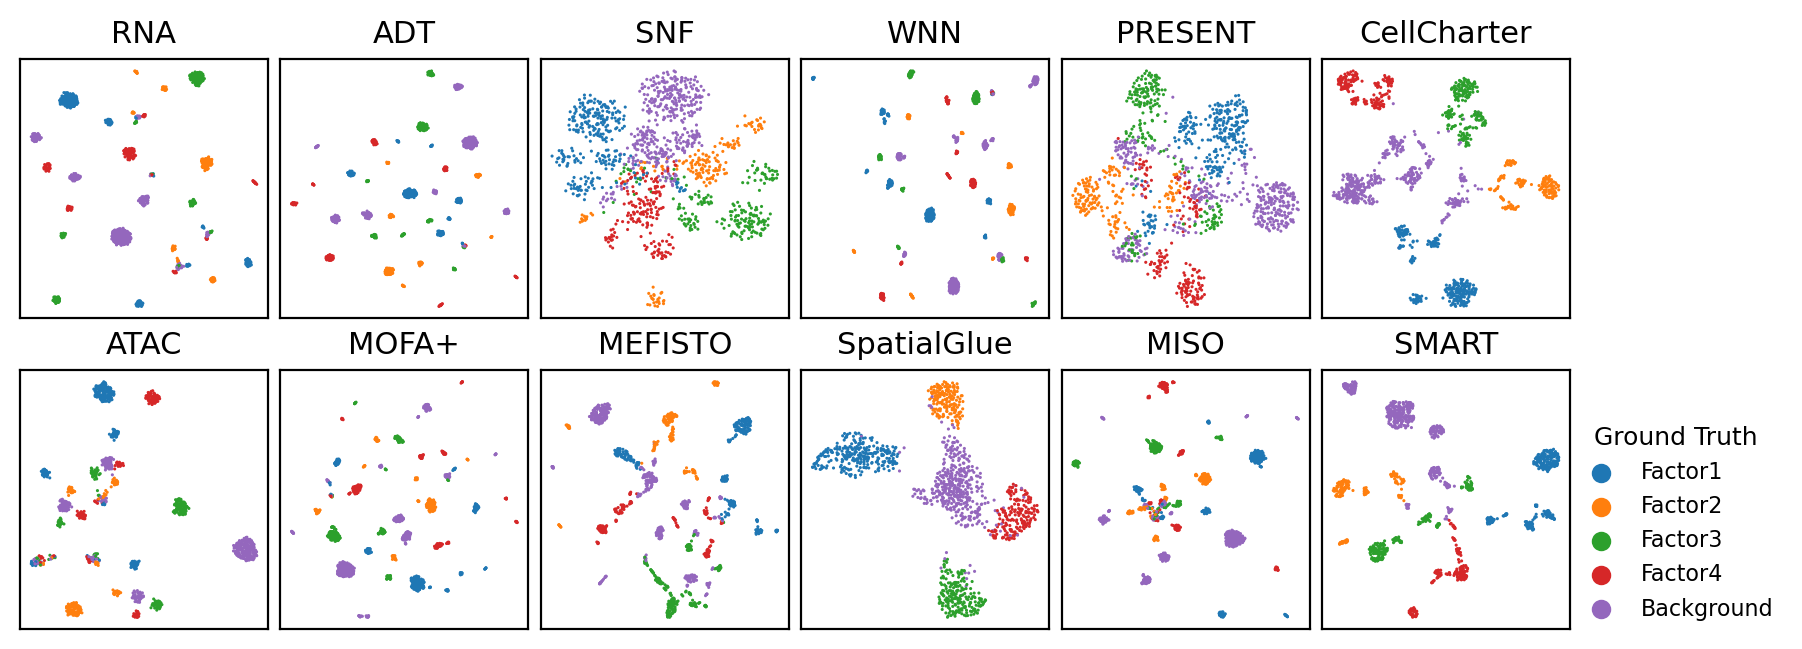

In [24]:
#gs = gridspec.GridSpec(2, 12)
fig, ax_list = plt.subplots(2, 6, figsize=(10, 3.7),dpi=200)
plt.subplots_adjust(hspace=0.2, wspace=0.05)

adata_WNN=sc.read_h5ad(result_path+"adata_WNN.h5ad")
adata_SNF=sc.read_h5ad(result_path+"adata_SNF.h5ad")

for i,j in enumerate(['RNA',  'ADT', 'SNF','WNN', 'PRESENT','CellCharter']+[  'ATAC','MOFA+', 'MEFISTO', 'SpatialGlue','MISO','SMART']):

    ax=ax_list[i//6,i%6]
    if j=="WNN":
        adata_WNN.obs['cluster']=adata.obs['cluster']
        sc.pl.umap(adata_WNN, color='cluster', ax=ax, title=j, s=5,palette=colordict2, show=False)
    elif j=="SNF":
        adata_SNF.obs['cluster']=adata.obs['cluster']
        sc.pl.umap(adata_SNF, color='cluster', ax=ax, title=j, s=5,palette=colordict2, show=False)
    else:
        sc.pp.neighbors(adata, use_rep="X_"+j, n_neighbors=10)
        sc.tl.umap(adata)
        sc.pl.umap(adata, color='cluster', ax=ax, title=j, s=5,palette=colordict2, show=False)
    ax.set_title(j,size=11)
    ax.set_xlabel("")
    ax.set_ylabel("")
    if i!=11:
        ax.get_legend().remove()
    else:
        ax.legend(loc=(1,0),frameon=False,title='Ground Truth')
fig.savefig("Umap2.svg",format="svg",bbox_inches='tight',transparent=True)

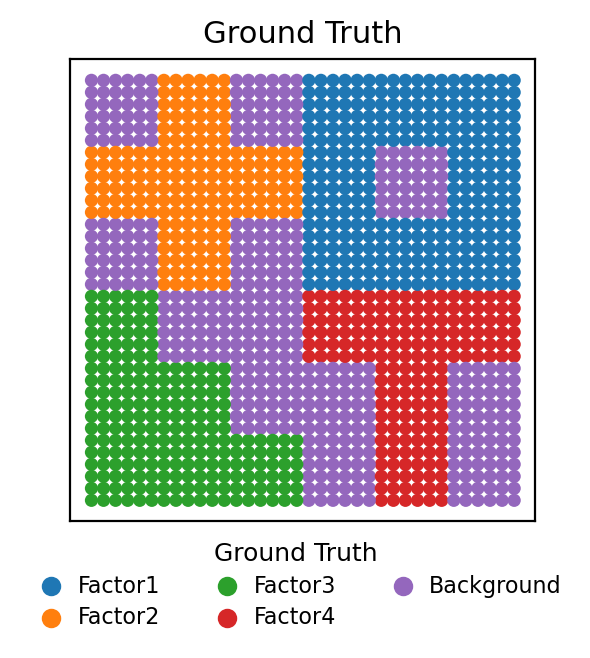

In [37]:
fig, ax = plt.subplots(1, 1, figsize=(3, 3),dpi=200)
sc.pl.embedding(adata, basis='spatial', color='cluster', ax=ax, title='Ground Truth',palette=colordict2, s=90,show=False)
ax.set_title("Ground Truth",size=11)
ax.set_xlabel("")
ax.set_ylabel("")
ax.legend(bbox_to_anchor=(1.1, -0.0),frameon=False,ncol=3,labelspacing=0.4,handletextpad=0.2,title="Ground Truth")
plt.show()
fig.savefig("GT.svg",format="svg",bbox_inches='tight',transparent=True)

In [43]:
adata

AnnData object with n_obs × n_vars = 1296 × 1000
    obs: 'anno', 'WNN_5', 'SNF_5', 'MOFA+_5', 'MEFISTO_5', 'mclust', 'RNA_5', 'ADT_5', 'ATAC_5', 'PRESENT_5', 'SpatialGlue_5', 'SMART_5', 'CellCharter_5', 'MISO_5', 'cluster'
    var: 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'hvg', 'log1p', 'neighbors', 'RNA_5_colors', 'ADT_5_colors', 'SNF_5_colors', 'WNN_5_colors', 'PRESENT_5_colors', 'CellCharter_5_colors', 'ATAC_5_colors', 'MOFA+_5_colors', 'MEFISTO_5_colors', 'SpatialGlue_5_colors', 'MISO_5_colors', 'SMART_5_colors', 'umap', 'cluster_colors'
    obsm: 'X_ADT', 'X_ADT_pca', 'X_ATAC', 'X_ATAC_pca', 'X_CellCharter', 'X_CellCharter_pca', 'X_MEFISTO', 'X_MEFISTO_pca', 'X_MISO', 'X_MISO_pca', 'X_MOFA+', 'X_MOFA+_pca', 'X_PRESENT', 'X_PRESENT_pca', 'X_RNA', 'X_RNA_pca', 'X_SMART', 'X_SMART_pca', 'X_SpatialGlue', 'X_SpatialGlue_pca', 'nsfac', 'spatial', 'spfac', 'X_umap'
    varm: 'nsload', 'spload'
    layers: 'coun

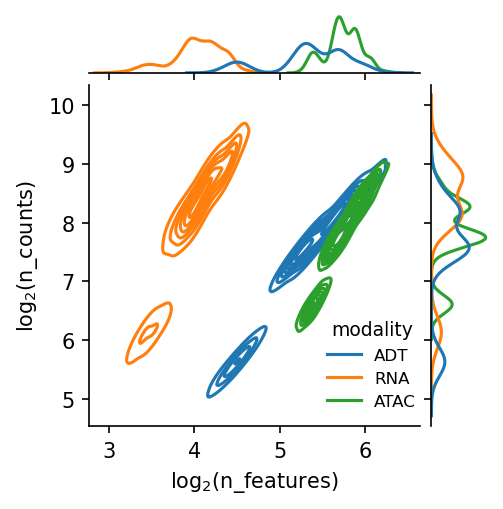

In [44]:
file_fold="../../datasets/simulated_data/"

adata_omics1 = sc.read_h5ad(file_fold + 'adata_RNA.h5ad')
adata_omics2 = sc.read_h5ad(file_fold + 'adata_ADT.h5ad')
adata_omics3 = sc.read_h5ad(file_fold + 'adata_ATAC.h5ad')

adata_omics1.var_names_make_unique()
adata_omics2.var_names_make_unique()
adata_omics3.var_names_make_unique()

sc.pp.filter_cells(adata_omics1, min_genes=20)
adata_omics1.obs["n_counts"]=adata_omics1.X.sum(axis=1)

sc.pp.filter_cells(adata_omics2, min_genes=20)
adata_omics2.obs["n_counts"]=adata_omics2.X.sum(axis=1)

sc.pp.filter_cells(adata_omics3, min_genes=20)
adata_omics3.obs["n_counts"]=adata_omics3.X.sum(axis=1)

import numpy as np
df=pd.DataFrame()
for i,j in zip([adata_omics1,adata_omics2,adata_omics3],["ADT","RNA","ATAC"]):
    f=i.obs.copy()
    f=np.log(f)
    f["mod"]=j
    df=pd.concat([df,f])
df.columns=[r"log$_{2}$(n_features)",r"log$_{2}$(n_counts)","modality"]

import seaborn as sns
plt.rcParams['legend.frameon'] = False
plt.rcParams['legend.loc'] = (0.7,0.03) 

with plt.rc_context({'figure.dpi':150}):
    mx=sns.jointplot(data=df, x=r"log$_{2}$(n_features)", y=r"log$_{2}$(n_counts)", hue="modality", fill=False,kind="kde",height=3.5)
    plt.savefig("dis.svg",format="svg",bbox_inches='tight',transparent=True)